In [1]:
import pyodbc
import pandas as pd

# connection 
conn = pyodbc.connect(
    "Driver={SQL Server};"
    "Server=DESKTOP-UR57B5H\\SQLEXPRESS;"  
    "Database=CleanedAdventureWorks;"
    "Trusted_Connection=yes;"
)


In [6]:
saleslt_address=pd.read_sql('select*from SalesLT_Address',conn)
saleslt_customer=pd.read_sql('select* from SalesLT_Customer',conn)
saleslt_customeraddress=pd.read_sql('select* from SalesLT_CustomerAddress',conn)
saleslt_product=pd.read_sql('select* from SalesLT_Product',conn)
saleslt_productcategory=pd.read_sql('select * from SalesLT_ProductCategory',conn)
saleslt_productmodel=pd.read_sql('select * from SalesLT_ProductModel',conn)
saleslt_productmodelproductproductdescription=pd.read_sql('select* from SalesLT_ProductModelProductDescription',conn)
saleslt_salesorderdetail=pd.read_sql('select* from SalesLT_SalesOrderDetail',conn)
saleslt_salesorderheader=pd.read_sql('select* from SalesLT_SalesOrderHeader',conn)
saleslt_productdescription=pd.read_sql('select* from SalesLT_ProductDescription',conn)

C:\Users\HP\AppData\Local\Temp\ipykernel_26384\1044123.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  saleslt_address=pd.read_sql('select*from SalesLT_Address',conn)
C:\Users\HP\AppData\Local\Temp\ipykernel_26384\1044123.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  saleslt_customer=pd.read_sql('select* from SalesLT_Customer',conn)
C:\Users\HP\AppData\Local\Temp\ipykernel_26384\1044123.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  saleslt_customeraddress=pd.read_sql('select* from SalesLT_CustomerAddress',co

In [8]:
sales_data = (saleslt_salesorderheader
    .merge(saleslt_salesorderdetail, on="SalesOrderID")
    .merge(saleslt_product, on="ProductID")
    .merge(saleslt_customer, on="CustomerID", suffixes=("", "_cust"))
    .merge(saleslt_customeraddress, on="CustomerID", suffixes=("", "_ca"))
    .merge(saleslt_address, left_on="AddressID", right_on="AddressID", suffixes=("", "_addr"))
)


In [ ]:
import plotly.graph_objects as go


sales_country_product = (
    sales_data.groupby(["CountryRegion", "Name"])["LineTotal"]
    .sum()
    .reset_index()
)

fig = go.Figure()

for product in sales_country_product["Name"].unique():
    product_data = sales_country_product[sales_country_product["Name"] == product]
    fig.add_trace(
        go.Bar(
            x=product_data["CountryRegion"],
            y=product_data["LineTotal"],
            name=product,
            hovertemplate="<b>Product:</b> %{text}<br><b>Sales:</b> %{y}<extra></extra>",
            text=product_data["Name"],  
        )
    )

fig.update_layout(
    barmode="group",  
    title="Sales by Country and Product",
    xaxis_title="Country",
    yaxis_title="Sales",
)

fig.show()



In [11]:
#to make sure canda doesn'thave any sales
canada_sales = sales_data[sales_data["CountryRegion"] == "Canada"]
print(canada_sales[["CustomerID", "LineTotal"]].head())
print("Total sales from Canada:", canada_sales["LineTotal"].sum())


Empty DataFrame
Columns: [CustomerID, LineTotal]
Index: []
Total sales from Canada: 0.0


In [14]:

customer_location = (
    saleslt_customer
    .merge(saleslt_customeraddress, on="CustomerID")
    .merge(saleslt_address, on="AddressID")
)


In [ ]:
import plotly.express as px


uk_customers = customer_location[customer_location["CountryRegion"] == "UK"]

uk_city_counts = (
    uk_customers.groupby("City")["CustomerID"]
    .nunique()
    .reset_index(name="CustomerCount")
)

fig = px.pie(
    uk_city_counts,
    names="City",
    values="CustomerCount",
    title="Customer Distribution by City (UK)",
    hole=0.3  
)

fig.show()


The analysis indicates that advertising efforts should be increased across all UK cities, with the exception of London, which already demonstrates strong customer engagement

In [ ]:
usa_customers = customer_location[customer_location["CountryRegion"] == "USA"]


usa_city_counts = (
    usa_customers.groupby("City")["CustomerID"]
    .nunique()
    .reset_index(name="CustomerCount")
)


top_15_cities = usa_city_counts.sort_values("CustomerCount", ascending=False).head(15)


fig = px.pie(
    top_15_cities,
    names="City",
    values="CustomerCount",
    title="Top 15 Cities by Customer Count (USA)",
    hole=0.3
)

fig.show()


Sales in the USA are relatively well-distributed across the top 15 cities. However, cities such as Bellingham and Renton, along with other cities with a similar share of total customers (around 5.56%), demonstrate lower engagement and could benefit from targeted marketing efforts to boost sales in these areas

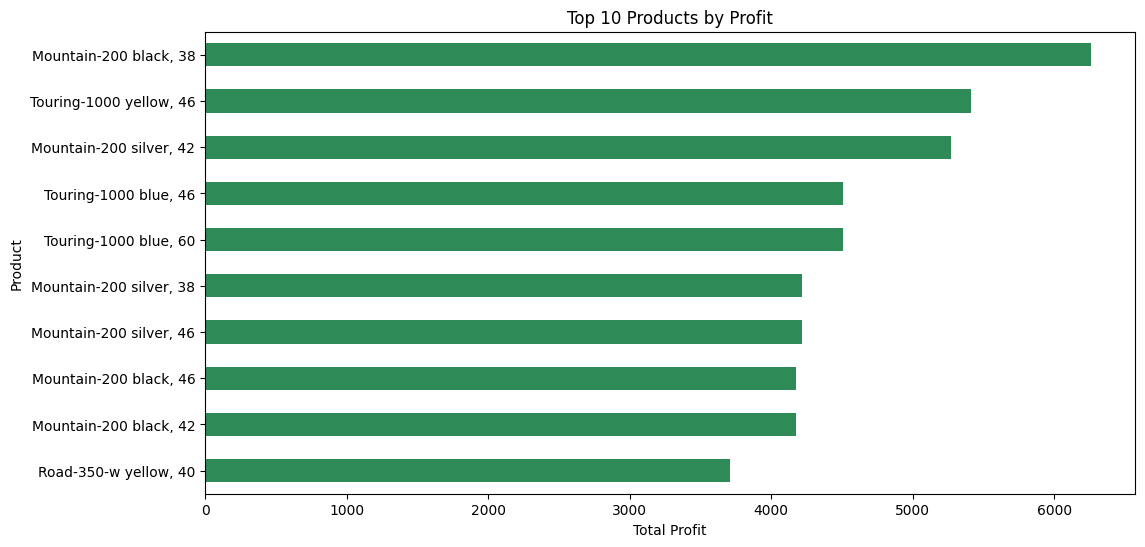

In [22]:
import matplotlib.pyplot as plt


top_profit = sales_data.groupby("Name")["MarginProfit"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12,6))
top_profit.plot(kind="barh", color="seagreen")
plt.title("Top 10 Products by Profit")
plt.xlabel("Total Profit")
plt.ylabel("Product")
plt.gca().invert_yaxis() 
plt.show()



In [20]:
product_sales = (
    sales_data.groupby("Name")
    .apply(lambda x: (x["OrderQty"] * x["UnitPrice"]).sum())
    .reset_index(name="TotalSales")
    .sort_values("TotalSales", ascending=False)
    .head(10)  
)

C:\Users\HP\AppData\Local\Temp\ipykernel_26384\3255802775.py:3: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



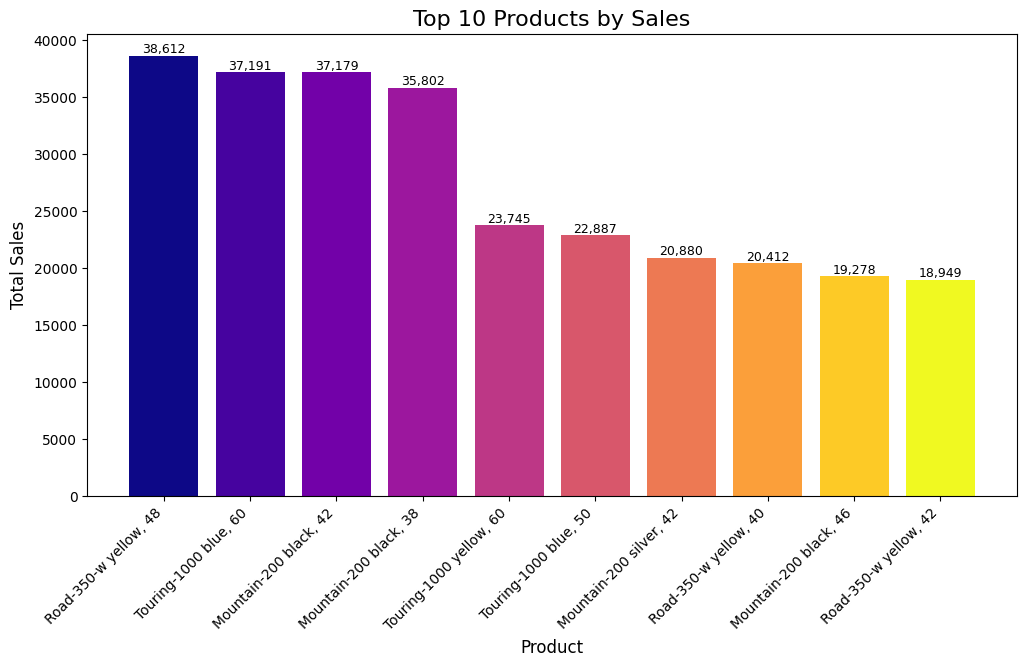

In [21]:
import matplotlib.pyplot as plt
import numpy as np

colors = plt.cm.plasma(np.linspace(0, 1, len(product_sales)))

plt.figure(figsize=(12, 6))
bars = plt.bar(product_sales["Name"], product_sales["TotalSales"], color=colors)
plt.title("Top 10 Products by Sales", fontsize=16)
plt.xlabel("Product", fontsize=12)
plt.ylabel("Total Sales", fontsize=12)
plt.xticks(rotation=45, ha="right")

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:,.0f}", 
             ha="center", va="bottom", fontsize=9)

plt.show()



In [25]:
import dash
from dash import dcc, html
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# -----------------------------
# Chart 1: Sales by Country & Product (grouped bar)
sales_country_product = (
    sales_data.groupby(["CountryRegion", "Name"])["LineTotal"]
    .sum()
    .reset_index()
)
fig_sales_country = go.Figure()
for product in sales_country_product["Name"].unique():
    product_data = sales_country_product[sales_country_product["Name"] == product]
    fig_sales_country.add_trace(
        go.Bar(
            x=product_data["CountryRegion"],
            y=product_data["LineTotal"],
            name=product,
            hovertemplate="<b>Product:</b> %{text}<br><b>Sales:</b> %{y}<extra></extra>",
            text=product_data["Name"]
        )
    )
fig_sales_country.update_layout(
    barmode="group",
    title="Sales by Country and Product",
    xaxis_title="Country",
    yaxis_title="Sales"
)

# -----------------------------
# Chart 2: UK Customer Distribution (pie)
uk_customers = customer_location[customer_location["CountryRegion"] == "UK"]
uk_city_counts = (
    uk_customers.groupby("City")["CustomerID"]
    .nunique()
    .reset_index(name="CustomerCount")
)
fig_uk_pie = px.pie(
    uk_city_counts,
    names="City",
    values="CustomerCount",
    title="Customer Distribution by City (UK)",
    hole=0.3
)

# -----------------------------
# Chart 3: USA Top 15 Cities Customer Distribution (pie)
usa_customers = customer_location[customer_location["CountryRegion"] == "USA"]
usa_city_counts = (
    usa_customers.groupby("City")["CustomerID"]
    .nunique()
    .reset_index(name="CustomerCount")
)
top_15_cities = usa_city_counts.sort_values("CustomerCount", ascending=False).head(15)
fig_usa_pie = px.pie(
    top_15_cities,
    names="City",
    values="CustomerCount",
    title="Top 15 Cities by Customer Count (USA)",
    hole=0.3
)

# -----------------------------
# Chart 4: Top Products by Sales (bar chart)
product_sales = sales_data.groupby("Name")["LineTotal"].sum().sort_values(ascending=False).head(10)
fig_top_sales = px.bar(
    product_sales,
    x=product_sales.index,
    y=product_sales.values,
    color=product_sales.values,
    color_continuous_scale="Plasma",
    labels={"x":"Product","y":"Total Sales"},
    title="Top 10 Products by Sales"
)

# -----------------------------
# Chart 5: Top Products by Profit (horizontal bar)
top_profit = sales_data.groupby("Name")["MarginProfit"].sum().sort_values(ascending=False).head(10)
fig_top_profit = px.bar(
    top_profit,
    x=top_profit.values,
    y=top_profit.index,
    orientation="h",
    color=top_profit.values,
    color_continuous_scale="Viridis",
    labels={"x":"Profit","y":"Product"},
    title="Top 10 Products by Profit"
)

# -----------------------------
# Dash App
app = dash.Dash(__name__)
app.layout = html.Div([
    html.H1("Sales & Customer Dashboard", style={"textAlign":"center"}),

    html.Div([
        dcc.Graph(figure=fig_sales_country),
        dcc.Graph(figure=fig_top_sales)
    ], style={"display":"flex","justifyContent":"space-around"}),

    html.Div([
        dcc.Graph(figure=fig_top_profit),
        dcc.Graph(figure=fig_uk_pie)
    ], style={"display":"flex","justifyContent":"space-around"}),

    html.Div([
        dcc.Graph(figure=fig_usa_pie)
    ], style={"display":"flex","justifyContent":"center"})
])

if __name__ == "__main__":
    app.run(debug=True)
